In [82]:
class Node:
    def __init__(self, id, radius=None, total_time=None, level=0,end_point=None,E_UAV = None,E_UGV = None):
        self.id = id
        self.radius = radius
        self.total_time = total_time
        self.level = level
        self.children = []
        self.E_UAV = E_UAV
        self.E_UGV = E_UGV
        self.visit_count = 0
        self.end_point = end_point
        self.value = 0.0  # For MCTS
        self.parent = None  # For MCTS

    def add_child(self, node):
        """Adds a child to the current node."""
        node.level = self.level + 1
        node.parent = self  # Set parent for MCTS
        self.children.append(node)
        
    def delete_child(self, node):
        """Removes a child from the current node."""
        if node in self.children:
            self.children.remove(node)

    def traverse(self):
        """Traverses and displays the tree starting from the current node."""
        print(f"Node ID: {self.id}, Radius: {self.radius}, Total Time: {self.total_time}, Level: {self.level}, E_UAV: {self.E_UAV}, E_UGV: {self.E_UGV}, Visits: {self.visit_count}, Value: {self.value}")
        for child in self.children:
            child.traverse()

    def get_nodes(self):
        """Returns all nodes in the tree starting from the current node."""
        nodes = [self]
        for child in self.children:
            nodes.extend(child.get_nodes())
        return nodes

    def ucb1(self, exploration_constant=1.41):
        """Calculates the UCB1 value for MCTS."""
        if self.visit_count == 0:
            return float('inf')
        parent_visits = self.parent.visit_count if self.parent is not None else 1
        return self.value / self.visit_count + exploration_constant * math.sqrt(
            math.log(parent_visits) / self.visit_count)

    def best_child(self):
        """Returns the best child based on UCB1 values."""
        return min(self.children, key=lambda node: node.ucb1(), default=None)

    def fully_expanded(self):
        """Checks if the node is fully expanded."""
        return len(self.radius) == len(waypoints) - 1  # -1 since the sequence length is one less than waypoints

    def update(self, reward):
        """Updates the node's value and visit count based on the given reward."""
        self.visit_count += 1
        self.value += reward




In [83]:
import numpy as np
from Common_function import *
import matplotlib.pyplot as plt
from itertools import product
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

x = 3  #how are is the distance set
Total_E_UGV = 500000
Total_E_UAV = 15000
UAV_E_cost = 1250

UGV_E_cost_with_UAV = 1000
UGV_E_cost_without_UAV = 800
Charging_speed = 1000
speed_uav =30
speed_ugv =10
ten_minets = 1
survey_time = ten_minets/6
UAV_E_s_cost = 2500*ten_minets


# waypoints = [(0,0),(10,10),(15,3),(20,12.5)] #4
# plan_output = "0 -> 1 -> 2 -> 3 -> 0"

# waypoints = [(0,0),(10,10),(15,3),(20,12.5),(30,-2.5),(10,-5)] # 6 
# plan_output = "0 -> 5 -> 2 -> 4 -> 3 -> 1 -> 0"

waypoints = [(0, 0),(11, 54),(4, 49),(69, 26),(12, 39),(25, 1),(17, 12),(38, 11),(28, 49),(52, 36),(36, 27)] #10
plan_output = "0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 3 -> 7 -> 5 -> 0"


# waypoints = [(0, 0),(11, 54),(4, 49),(69, 26),(12, 39),(25, 1),(17, 12),(38, 11),(28, 49),(52, 36),(36, 27),(56, 44),(22, 58)] #12
# plan_output = "0 -> 6 -> 4 -> 2 -> 1 -> 12 -> 8 -> 11 -> 3 -> 9 -> 10 -> 7 -> 5 -> 0"

# waypoints = [(0, 0),(54, 85),(8, 92),(25, 32),(71, 1),(6, 75),(21, 87),(35, 48),(13, 55),(75, 44),(91, 95),(62, 77),(53, 20),(79, 70),(40, 7)] # 15 
# plan_output = "0 -> 14 -> 12 -> 4 -> 9 -> 13 -> 10 -> 11 -> 1 -> 6 -> 2 -> 5 -> 8 -> 7 -> 3 -> 0"


max_radius = ((Total_E_UAV - UAV_E_s_cost) / UAV_E_cost) / 2
radii = np.linspace(max_radius, 1.0, x)
ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
ordered_points.append(ordered_points[0])


In [84]:
def compute_path_for_one_point(ordered_points, point_index, radius, speed_ugv, speed_uav, survey_time):
    if point_index <= 0 or point_index >= len(ordered_points) - 1:
        raise ValueError("Invalid point index. It should be between 1 and len(ordered_points) - 2.")
    
    UGV_outer_path = []
    UGV_path = []
    UAV_path = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone = []
    # chord_end = None
    # prev_chord_end = None
    # final_wait_set = []
    radius_set = []
    final_wait_time = 0 
    point = ordered_points[point_index]
    
    # Assuming angle_between_points and point_on_circle functions are defined previously
    angle = angle_between_points(ordered_points[point_index - 1], ordered_points[point_index])
    nextangle = angle_between_points(ordered_points[point_index], ordered_points[point_index + 1])
    chord_start = point_on_circle(ordered_points[point_index], angle - np.pi, radius)
    chord_end = point_on_circle(ordered_points[point_index], nextangle, radius)
    prev_chord_end = point_on_circle(ordered_points[point_index - 1],angle,radius)
    radius_set.append(radius)
    
    if point_index > 1 and circles_overlap(ordered_points[point_index], radius, ordered_points[point_index - 1], radius):
        chord_start = prev_chord_end

    # Assuming find_meeting_point_with_survey_final function is defined previously
    final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
        ordered_points[point_index], radius, chord_start, chord_end, 
        speed_ugv, speed_uav, survey_time
    )
    final_wait_time = final_wait_time
    
    if chord_start:
        UAV_path_segment = [chord_start, point, final_meeting_point]
        UAV_path.append(UAV_path_segment)
        UGV_path.append(chord_start)

        # Assuming calculate_UAV_inter_distances_inter function is defined previously
        UAV_path_segment_distance = calculate_UAV_inter_distances_inter(UAV_path_segment)
        if point_index == 1:
            UGV_outer_path.append([ordered_points[0], chord_start])
        else:
            UGV_outer_path.append([prev_chord_end, chord_start])
        # print(f"UGV_outer_path:{UGV_outer_path}")
    if chord_end:
        UGV_path.append(chord_end)

    # Assuming compute_distance function is defined previously
    inter_distance_without_drone = compute_distance(chord_start, final_meeting_point)
    inter_distance_with_drone = compute_distance(final_meeting_point, chord_end)
    UGVD_inter_without_drone.append(inter_distance_without_drone)
    UGVD_inter_with_drone.append(inter_distance_with_drone)
    
    return radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time

# Note: This function assumes the existence of functions like angle_between_points, point_on_circle, 
# find_meeting_point_with_survey_final, etc. which are not provided here. So, this function won't run as-is without those definitions.


In [85]:
# def calculate_UAV_inter_distances_inter(UAV_path):
#     UAV_inter_distances = 0
#     group_distance=0
#     # print(f"what I got in function:{UAV_path}")
#     for i in range(len(UAV_path) - 1):
#         group_distance += compute_distance(UAV_path[i], UAV_path[i + 1])
#     UAV_inter_distances=group_distance
#     # print(f"UAV_path:{UAV_path},UAV_inter_distances{UAV_inter_distances}")
#     return UAV_inter_distances


In [86]:
def add_node(parent, waypoint_index,nodes_in_order,node_counter):
        if waypoint_index >= len(nodes_in_order):
            return
        run_post_loop_code = False
        for r in radii:
            if waypoint_index == 1: # starting point, no charging need to be cal for the begining path
               
                radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time= compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)
                UGV_out_distance = compute_distance(ordered_points[0], UAV_path[0][0])
                UGV_inter_distance = compute_distance(UGV_path[0],UGV_path[1])
                UGV_distance = UGV_out_distance + UGV_inter_distance
                UAV_distances =UAV_path_segment_distance
                
                UGV_Trip_Cost = UGVD_inter_without_drone[0] * UGV_E_cost_without_UAV + UGV_out_distance * UGV_E_cost_with_UAV
                UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost

                charging_distance = UGVD_inter_with_drone[0]
              
                UGV_energy_remaining = Total_E_UGV - UGV_Trip_Cost
                UAV_energy_remaining = Total_E_UAV - UAV_Trip_Cost
                if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
                    return  # Indicating mission failed for both
               
                charging_distance = UGVD_inter_with_drone[0]
                if UAV_energy_remaining < Total_E_UAV:
                    charge_amount = min(Charging_speed * charging_distance , UAV_Trip_Cost, UGV_energy_remaining)
                    UGV_energy_remaining -= charge_amount
                    UAV_energy_remaining += charge_amount
                   
                if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
                    pass_flag = 1
                    pass
                else:
                    pass_flag = 0
                total_time = parent.total_time  + final_wait_time +UGV_distance / speed_ugv

            elif waypoint_index == (len(nodes_in_order) -1): # Ending point, don't charge the drone on the wayback
                # run_post_loop_code = True
                UAV_path = []
                final_wait_time = 0
                UGV_path = [parent.end_point,ordered_points[-1]]
                UGV_distance = compute_distance(parent.end_point,ordered_points[-1])
                total_time = parent.total_time + UGV_distance / speed_ugv 

                UGV_energy_remaining =parent.E_UGV
                UAV_energy_remaining =parent.E_UAV
                
                UGV_Trip_Cost = UGV_distance * UGV_E_cost_with_UAV
                UAV_Trip_Cost = 0
                UGV_energy_remaining -= UGV_Trip_Cost
                
                if UGV_energy_remaining < 0:
                    pass_flag = 1
                    pass
                else:
                    pass_flag = 2
                    run_post_loop_code = True
                    # print("end point flag ")
                
            else: #Any Mid point on the way 
                
                radius_set, UGV_path, UAV_path, UAV_path_segment_distance,UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone, final_wait_time= compute_path_for_one_point(ordered_points, waypoint_index, r, speed_ugv, speed_uav, survey_time)
                UGV_inter_distance = compute_distance(UGV_path[0],UGV_path[1])
                UGV_out_distance = compute_distance(parent.end_point,UGV_path[0])

                UGV_distance = UGV_out_distance + UGV_inter_distance

                UAV_distances =UAV_path_segment_distance
                
                UGV_Trip_Cost = UGVD_inter_without_drone[0] * UGV_E_cost_without_UAV + UGV_out_distance * UGV_E_cost_with_UAV
                UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost
                
                UAV_energy_remaining = parent.E_UAV
                UGV_energy_remaining = parent.E_UGV
              
                charging_distance = UGV_out_distance
                if UAV_energy_remaining < Total_E_UAV:
                    charge_amount = min(Charging_speed * charging_distance , (Total_E_UAV - UAV_energy_remaining), UGV_energy_remaining)
                    UGV_energy_remaining -= charge_amount
                    UAV_energy_remaining += charge_amount
                   
                
                UGV_energy_remaining = UGV_energy_remaining - UGV_Trip_Cost
                UAV_energy_remaining = UAV_energy_remaining - UAV_Trip_Cost
                
                charging_distance = UGVD_inter_with_drone[0]
                if UAV_energy_remaining < Total_E_UAV:
                    charge_amount = min(Charging_speed * charging_distance , (Total_E_UAV - UAV_energy_remaining), UGV_energy_remaining)
                    UGV_energy_remaining -= charge_amount
                    UAV_energy_remaining += charge_amount
                   
               
                if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
                    pass_flag = 1 
                    pass
                else: 
                    pass_flag = 0   
                    total_time = parent.total_time  + UGV_distance / speed_ugv + final_wait_time              
              
            if pass_flag == 1:
                pass

            elif  pass_flag == 0:
                child = Node(id=node_counter[0], radius=r, total_time=total_time)
                parent.add_child(child)
                child.E_UGV = UGV_energy_remaining
                child.E_UAV = UAV_energy_remaining
                child.end_point = UGV_path[-1]
                node_counter[0] += 1  # Increment global node ID counter
                add_node(child, waypoint_index + 1,nodes_in_order,node_counter) #recursive 
                # print(f"id:{child.id}, R:{r}, E_UGV :{UGV_energy_remaining},E_UAV:{UAV_energy_remaining}")
        if run_post_loop_code:
            # print(r)
            child = Node(id=node_counter[0], radius=None, total_time=total_time)
            parent.add_child(child)
            child.E_UGV = UGV_energy_remaining
            child.E_UAV = UAV_energy_remaining
            child.end_point = UGV_path[-1]
            node_counter[0] += 1


In [87]:

def tsp_output_to_tree(tsp_output, waypoints, radii):
    nodes_in_order = tsp_output.split()
    nodes_in_order = [int(node) for node in nodes_in_order if node.isdigit()]
    pass_flag = 0
    # Create root node (start)
    root = Node(id=0, radius=None, total_time=0)
    
    # Global counter for node ID
    node_counter = [1]  # Using a list so it's mutable inside nested functions

    
    add_node(root, 1 , nodes_in_order,node_counter)

    return root



In [88]:
def draw_tree(root):
    def add_edges(graph, node):
        for child in node.children:
            graph.add_edge(node.id, child.id)
            add_edges(graph, child)

    G = nx.DiGraph()
    add_edges(G, root)

    # Get all nodes and sort by level
    all_nodes = sorted(root.get_nodes(), key=lambda node: node.level)

    # Count nodes per level
    level_counts = defaultdict(int)

    # Assign positions
    pos = {}
    for node in all_nodes:
        pos[node.id] = (level_counts[node.level], -node.level)
        level_counts[node.level] += 1

    # Adjust x-positions to center nodes on each level
    for node in all_nodes:
        x_adjust = -0.5 * (level_counts[node.level] - 1)
        pos[node.id] = (pos[node.id][0] + x_adjust, pos[node.id][1])
    
    # Dynamic figure size
    num_nodes = len(all_nodes)
    num_levels = len(level_counts)
    fig_width = max(10, num_nodes * 0.5)
    fig_height = max(5, num_levels * 2)
    plt.figure(figsize=(fig_width, fig_height))

    # Nodes
    nx.draw_networkx_nodes(G, pos, node_size=500)

    # Edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, width=2)

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Node data annotations
    for node in all_nodes:
        plt.annotate(
            f'T:{node.total_time:.2f}',
            xy=pos[node.id], textcoords='offset points', xytext=(-20,-30))

    plt.show()


In [89]:
import time
import csv

# Write the header of the CSV file just once
with open('DSP.csv', 'w', newline='') as csvfile:
    fieldnames = ['DFS_runtime', 'mission_time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

for i in range(100):
    start_time = time.time()
    root = tsp_output_to_tree(plan_output, waypoints, radii)
    end_time = time.time()
    duration_mcts_v2 = end_time - start_time
    print(f"DFS took {duration_mcts_v2:.4f} seconds to execute.")
    
    result = find_min_total_time_node_at_level(root,len(waypoints))
    total_time = result['total_time']
    
    # Open the CSV file in append mode to avoid overwriting
    with open('DSP.csv', 'a', newline='') as csvfile:
        fieldnames = ['DFS_runtime', 'mission_time']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Write the data
        writer.writerow({'DFS_runtime': duration_mcts_v2, 'mission_time': total_time})


DFS took 1.3232 seconds to execute.
DFS took 1.3225 seconds to execute.


KeyboardInterrupt: 

In [ ]:

def generate_combinations(plan_output):
    # Split the plan_output by '->' and remove spaces
    nodes = [node.strip() for node in plan_output.split('->')]
    
    # Exclude the starting and ending '0' for permutations
    internal_nodes = nodes[1:-1]
    
    # Generate all permutations of the internal nodes
    permutations = itertools.permutations(internal_nodes)
    
    # Construct the paths
    paths = ['0 -> ' + ' -> '.join(perm) + ' -> 0' for perm in permutations]
    
    return paths

In [90]:
plan_result = generate_combinations(plan_output)
plan_result[:10], len(plan_result)  # Displaying first 5 results and the total number of combinations


(['0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 3 -> 7 -> 5 -> 0',
  '0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 3 -> 5 -> 7 -> 0',
  '0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 7 -> 3 -> 5 -> 0',
  '0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 7 -> 5 -> 3 -> 0',
  '0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 5 -> 3 -> 7 -> 0',
  '0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 5 -> 7 -> 3 -> 0',
  '0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 3 -> 9 -> 7 -> 5 -> 0',
  '0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 3 -> 9 -> 5 -> 7 -> 0',
  '0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 3 -> 7 -> 9 -> 5 -> 0',
  '0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 3 -> 7 -> 5 -> 9 -> 0'],
 3628800)

In [91]:
import time
import csv

# Write the header of the CSV file just once
with open('BFBF.csv', 'w', newline='') as csvfile:
    fieldnames = ['DFS_runtime', 'mission_time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

for plan in plan_result:
    print(plan)
    start_time = time.time()
    root = tsp_output_to_tree(plan_output, waypoints, radii)
    end_time = time.time()
    duration_mcts_v2 = end_time - start_time
    print(f"DFS took {duration_mcts_v2:.4f} seconds to execute.")
    
    result = find_min_total_time_node_at_level(root,len(waypoints))
    
    total_time = result['total_time']
    root =[]

    # Open the CSV file in append mode to avoid overwriting
    with open('BFBF.csv', 'a', newline='') as csvfile:
        fieldnames = ['DFS_runtime', 'mission_time']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        # Write the data
        writer.writerow({'DFS_runtime': duration_mcts_v2, 'mission_time': total_time})
        total_time = 0


0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 3 -> 7 -> 5 -> 0
DFS took 1.3602 seconds to execute.
0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 3 -> 5 -> 7 -> 0
DFS took 1.2976 seconds to execute.
0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 7 -> 3 -> 5 -> 0
DFS took 1.2824 seconds to execute.
0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 7 -> 5 -> 3 -> 0
DFS took 1.3017 seconds to execute.
0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 5 -> 3 -> 7 -> 0
DFS took 1.3000 seconds to execute.
0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 9 -> 5 -> 7 -> 3 -> 0
DFS took 1.2945 seconds to execute.
0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 3 -> 9 -> 7 -> 5 -> 0
DFS took 1.2877 seconds to execute.
0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 3 -> 9 -> 5 -> 7 -> 0
DFS took 1.2882 seconds to execute.
0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 3 -> 7 -> 9 -> 5 -> 0
DFS took 1.2990 seconds to execute.
0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 3 -> 7 -> 5 -> 9 -> 0
DFS took 1.3507 seconds to execute.
0 -> 6 -> 4 -> 2 -> 1 -> 8 -> 10 -> 3 -> 5 -> 9 -> 7 -> 0
DF

KeyboardInterrupt: 

In [ ]:
import time



# Test the function with the provided plan_output

root = tsp_output_to_tree(plan_output, waypoints, radii)
# draw_tree(root)

In [ ]:
result = find_min_total_time_node_at_level(root,len(waypoints))
print(result)

{'id': 15, 'value': 0.0, 'total_time': 37.18957475973359, 'radius comb': [None, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, None]}


In [ ]:
def find_min_total_time_node_at_level(root, target_level):
    """
    Find the node with minimum node.total_time among all nodes at a specific node.level 
    and retrieve the path from that node back to the root.
    
    Parameters:
    - root: The root node of the tree.
    - target_level: The level at which we want to find the node with minimum total_time.
    
    Returns:
    - result: A dictionary containing the node's id, total_time, and the path from that node back to the root.
    """
    nodes_at_target_level = [node for node in root.get_nodes() if node.level == target_level]
    
    if not nodes_at_target_level:
        return None  # No nodes found at the target level
    
    # Find the node with the minimum total_time at the target level
    min_total_time_node = min(nodes_at_target_level, key=lambda node: node.total_time)
    
    # Retrieve the path from that node back to the root
    path = []
    current_node = min_total_time_node
    while current_node is not None:
        path.append(current_node.radius)
        current_node = current_node.parent
    path.reverse()  # Reverse the path to start from the root
    
    # Construct the result dictionary
    result = {
        "id": min_total_time_node.id,
        "total_time": min_total_time_node.total_time,
        "radius comb": path
    }
    
    return result
result = find_min_total_time_node_at_level(root,len(waypoints))


In [ ]:
# def find_top_3_min_total_time_nodes_at_level(root, target_level):
#     """
#     Find the top 3 nodes with minimum node.total_time among all nodes at a specific node.level 
#     and retrieve the paths from those nodes back to the root.
    
#     Parameters:
#     - root: The root node of the tree.
#     - target_level: The level at which we want to find the nodes with minimum total_time.
    
#     Returns:
#     - results: A list of dictionaries, each containing a node's id, total_time, and the path 
#       from that node back to the root.
#     """
#     nodes_at_target_level = [node for node in root.get_nodes() if node.level == target_level]
    
#     if not nodes_at_target_level:
#         return None  # No nodes found at the target level
    
#     # Sort the nodes by total_time and take the top 3
#     top_3_nodes = sorted(nodes_at_target_level, key=lambda node: node.total_time)[:3]
    
#     results = []
#     for min_total_time_node in top_3_nodes:
#         # Retrieve the path from the node back to the root
#         path = []
#         current_node = min_total_time_node
#         while current_node is not None:
#             path.append(current_node.radius)
#             current_node = current_node.parent
#         path.reverse()  # Reverse the path to start from the root
        
#         # Construct the result dictionary and append to the results list
#         results.append({
#             "id": min_total_time_node.id,
#             "total_time": min_total_time_node.total_time,
#             "radius comb": path
#         })
    
#     return results
# result = find_top_3_min_total_time_nodes_at_level(root,len(waypoints))
# print(result)

In [ ]:
radius_list = [x for x in result['radius comb'] if x is not None]
total_time = result['total_time']
result_in = [radius_list,total_time]
result_in

[[5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
 37.18957475973359]

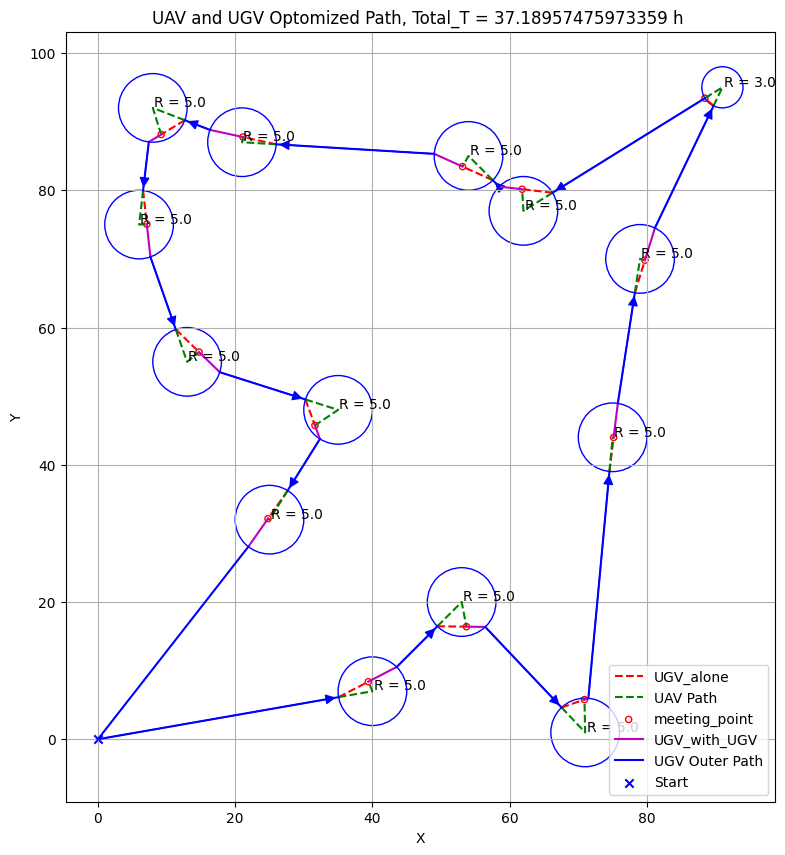

In [ ]:

radius_set ,UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone,final_wait_set= compute_optimized_paths_for_radius(ordered_points, radius_list, speed_ugv, speed_uav, survey_time)
# Plotting the updated paths with circles
plot_updated_paths_with_circles(UAV_path, UGV_outer_path, ordered_points, result_in)
